# Analysis Ratings & Reviews NIVEA.de


# Notebook 4: Final Steps - Spacy & Classification Models

#### Reading the data set with filtered reviews 

In [197]:
import pandas as pd
import spacy

reviews_filtered = pd.read_csv("reviews_filtered.csv")

#### Clean_doc() function 

We create a function that cleans our data

In [198]:
import emoji 
import re
import string

def clean_doc(doc):
    
    # All words in lowercase
    doc = doc.lower()
    
    # Removing emojis
    doc = emoji.get_emoji_regexp().sub(u'', doc)
    
    # Removing numbers
    doc = re.sub(r"[0-9]+", "", doc)
    
    # Tokenization
    tokens = doc.split()
    
    # Removing special characters
    tokens = [w.translate(str.maketrans('', '', string.punctuation)) for w in tokens]
    
    # Removing words with less than two letters, i.e. individual letters
    tokens = [word for word in tokens if len(word) > 1]
    
    # Returning the filtered tokens
    return ' '.join(tokens)

Now we apply the function to the "review_content" column and write the result in a separate list.

In [199]:
reviews = []

for text in reviews_filtered['review_content']:
    text = clean_doc(text)
    reviews.append(text)


In [200]:
reviews_filtered['review_content_clean'] = reviews

### SpaCy Module

Now we load SpaCy and the German language package.

In [201]:
import spacy

nlp = spacy.load("de_core_news_sm")

#### Default pipeline of the SpaCy model

In [202]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x2d846ba41c0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x2d83a1c5a00>),
 ('morphologizer',
  <spacy.pipeline.morphologizer.Morphologizer at 0x2d83a1c5460>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x2d854e45eb0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x2d83af89980>),
 ('lemmatizer', <spacy.pipeline.lemmatizer.Lemmatizer at 0x2d83af89800>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x2d8ffb8d040>)]

The pipeline consists of the following 7 steps:

* Tokenizer
* Tagger
* Morphologizier
* Parser
* Attribute Ruler
* Lemmatizer
* NER (Named Entitiy Recognition)

#### Defining our own SpaCy pipeline

We want to modify (respectively simplify) the default pipeline. The new SpaCy pipeline should only consist of 2 steps:

* Tokenizer

* Lemmatizer

In [203]:
nlp = spacy.load("de_core_news_sm", exclude = ['morphologizer', 'parser', 'attribute_ruler', 'ner', 'tagger'])

#### Checking the modified pipeline

In [204]:
nlp.analyze_pipes(pretty = True)


============================= Pipeline Overview =============================

#   Component    Assigns       Requires   Scores      Retokenizes
-   ----------   -----------   --------   ---------   -----------
0   tok2vec      doc.tensor                           False      
                                                                 
1   lemmatizer   token.lemma              lemma_acc   False      

✔ No problems found.


{'summary': {'tok2vec': {'assigns': ['doc.tensor'],
   'requires': [],
   'scores': [],
   'retokenizes': False},
  'lemmatizer': {'assigns': ['token.lemma'],
   'requires': [],
   'scores': ['lemma_acc'],
   'retokenizes': False}},
 'problems': {'tok2vec': [], 'lemmatizer': []},
 'attrs': {'doc.tensor': {'assigns': ['tok2vec'], 'requires': []},
  'token.lemma': {'assigns': ['lemmatizer'], 'requires': []}}}

We see: "No problems found". Now the pipeline consists of two steps only.

### Removing foreign language reviews from the data set

Now we want to remove foreign language reviews from our data set. We use the langdetector library. 

In [205]:
import langdetect
import langid

We use try-except execution. This ensures that in the case of errors (i.e. the language is not recognized), the abort is executed. The language is then assigned as "unknown".


In [206]:
reviews = reviews_filtered['review_content_clean']
languages_langdetect = []

for text in reviews :
    
    try:
        result = langdetect.detect_langs(text)
        result = str(result[0])[:2]
    
    except:
        result = 'unknown'
    
    finally:
        languages_langdetect.append(result)

#### Checking the results

In [207]:
pd.Series(languages_langdetect).value_counts() # detected languages and their counts

de         80471
en           279
no           183
fr           127
da           103
nl            74
af            60
ro            59
unknown       51
sv            46
et            41
it            31
ca            30
sk            20
lv            17
fi            13
es            13
id            12
sl            11
sq            10
cy             8
pl             5
pt             4
hr             4
tl             3
tr             3
so             2
bg             1
ru             1
zh             1
lt             1
hu             1
dtype: int64

#### Checking the reviews that were classified as "English"

In [208]:
reviews_filtered['language'] = languages_langdetect
reviews_filtered[reviews_filtered['language'] == "en"].head(3)


,Unnamed: 0,id,date,product_id,product_url,product_title,review_title,review_content,review_score,display_name,day_of_week,category,review_content_clean,review_content_tokenized,language
1059,14172,170052491,2019-06-06,89258.0,https://www.nivea.de/produkte/micellair-skin-b...,micellair skin breathe mizellenwasser trockene...,Super!,Dieses Produkt does what it should. Austrockne...,5,Jessica,Thursday,other,dieses produkt does what it should austrocknet...,dieses produkt does what it should austrockne...,en
1598,14711,170053566,2019-12-14,82808.0,https://www.nivea.de/produkte/active-protect-d...,active protect deo roll-on,Der Deo Roller einfach Klasse,Der Deo Roll ACTIVE PROTECT ist einfach guter ...,5,Günther,Saturday,other,der deo roll active protect ist einfach guter ...,der deo roll active protect ist einfach guter ...,en
2482,15595,170054891,2020-04-02,80052.0,https://www.nivea.de/produkte/fresh-ocean-deo-...,fresh ocean deo spray,Toll,Fresh ocean ist die beste spray,5,Dino,Thursday,other,fresh ocean ist die beste spray,fresh ocean ist die beste spray,en


We can see that this doesn't work perfectly yet. For example, texts with mixed languages or reviews with English product names (which occurs more frequently) are classified as English. 


We attached the variable of the recognized language back to the data frame, so now we can filter the data for German texts.

#### Filtering the data set for German reviews

In [209]:
reviews_filtered = reviews_filtered[reviews_filtered['language'] == "de"]

Now we apply our SpaCy pipeline that we defined above.
We first write the results in individual lists and will attach them later to the dataframe.

In [210]:
tokenized = []
tokens_ex_stop = []
lemmatized = []

for doc in nlp.pipe(reviews_filtered['review_content_clean']):
    tokenized.append([n.text for n in doc])
    tokens_ex_stop.append(list([token.text for token in doc if token.is_stop != True and token.is_punct != True]))
    lemmatized.append([n.lemma_ for n in doc if not n.is_stop])

We created two lists: Tokenized and Tokenized Ex Stop.
The latter list only includes tokens that are not stopwords.

In Spacy, the information "is_stop" (token.is_stop) exists for each token and thus it is possible to remove stop words immediately.

Now we render the lists back to the data frame.

In [211]:
reviews_filtered['review_content_tokenized'] = tokenized
reviews_filtered['review_content_tokenized_ex_stopwords'] = tokens_ex_stop
reviews_filtered['review_content_lemmatized'] = lemmatized 

### Classification Models

Now we want to test different classification models in order to find the best classifier for our "Review Score Classification Problem", that is to predict the review score on the basis of the review text. This approach should help to prevent bad ratings by mistake, with the review text being positive.

#### Creating a train-test split

In [213]:
import random
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(reviews_filtered.review_content_lemmatized, 
                                                    reviews_filtered.review_score, 
                                                    train_size=0.8, # default is 75% / 25% train-test split
                                                    random_state = 123)

#### Implementing TF-IDF Vectorizer vs. CountVectorizer

TF-IDF Vectorizer and CountVectorizer are algorithms that transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction.

In [214]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


def dummy_fun(doc):
    return doc

countvec = CountVectorizer(
    analyzer = 'word',
    tokenizer = dummy_fun,
    preprocessor = dummy_fun)

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)


Since the accuracy of TF-IDF was slightly better, we use this vectorizer in the following classification models

### Logistic Regression

In [215]:
from sklearn.linear_model import LogisticRegression

lgr = LogisticRegression(class_weight = "balanced", max_iter = 1000)
lgr.fit(tfidf.fit_transform(X_train), y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [216]:
preds_lgr = lgr.predict(tfidf.transform(X_test))

In [217]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

print(classification_report(preds_lgr, y_test))
cm = confusion_matrix(preds_lgr, y_test, labels = lgr.classes_)

              precision    recall  f1-score   support

           1       0.57      0.30      0.40       385
           2       0.27      0.09      0.13       513
           3       0.45      0.18      0.26      1537
           4       0.45      0.36      0.40      4047
           5       0.71      0.88      0.79      9613

    accuracy                           0.64     16095
   macro avg       0.49      0.36      0.40     16095
weighted avg       0.61      0.64      0.61     16095



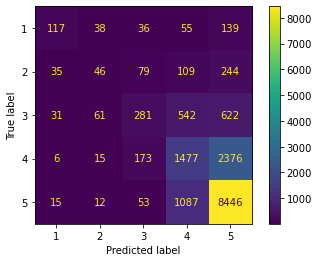

In [218]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = lgr.classes_)

disp.plot()

### Linear Support Vector Machine

In [149]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC, LinearSVC

#### LinearSVC

In [150]:
lsvc = LinearSVC(max_iter = 1000)
lsvc.fit(tfidf.fit_transform(X_train), y_train)

LinearSVC()

In [151]:
preds_lsvc = lsvc.predict(tfidf.transform(X_test))

In [152]:
print(classification_report(preds_lsvc, y_test))

              precision    recall  f1-score   support

           1       0.39      0.68      0.49       122
           2       0.06      0.39      0.10        28
           3       0.13      0.39      0.20       188
           4       0.26      0.51      0.35      1685
           5       0.95      0.80      0.87     14076

    accuracy                           0.77     16099
   macro avg       0.36      0.56      0.40     16099
weighted avg       0.86      0.77      0.80     16099



#### SVC , kernel ="linear"

In [82]:
svc_linear = SVC(max_iter = 1000, kernel='linear') # The default SVC kernel is radial basis function (RBF)
svc_linear.fit(tfidf.fit_transform(X_train), y_train)

C:\Users\Valeria\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(kernel='linear', max_iter=1000)

In [103]:
preds_svc_linear = svc_linear.predict(tfidf.transform(X_test))

In [104]:
print(classification_report(preds_svc_linear, y_test))

              precision    recall  f1-score   support

           1       0.43      0.55      0.48       178
           2       0.07      0.34      0.12        50
           3       0.33      0.15      0.21      1580
           4       0.27      0.24      0.26      4479
           5       0.74      0.80      0.77     13833

    accuracy                           0.62     20120
   macro avg       0.37      0.42      0.37     20120
weighted avg       0.60      0.62      0.60     20120



#### SVC , kernel ="rbf"

In [72]:
svc = SVC(kernel='rbf', max_iter = 1000)
svc.fit(tfidf.fit_transform(X_train), y_train)


C:\Users\Valeria\anaconda3\lib\site-packages\sklearn\svm\_base.py:255: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn('Solver terminated early (max_iter=%i).'


SVC(max_iter=1000)

In [73]:
preds_svc = svc.predict(tfidf.transform(X_test))

In [74]:
print(classification_report(preds_svc, y_test))

              precision    recall  f1-score   support

           1       0.31      0.59      0.40       119
           2       0.02      0.36      0.03        11
           3       0.58      0.09      0.16      4759
           4       0.16      0.22      0.18      2984
           5       0.66      0.81      0.73     12247

    accuracy                           0.55     20120
   macro avg       0.34      0.41      0.30     20120
weighted avg       0.57      0.55      0.51     20120



### Decision Tree Classifier

In [114]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [115]:
dtc = DecisionTreeClassifier()
dtc.fit(tfidf.fit_transform(X_train), y_train)


DecisionTreeClassifier()

In [116]:
preds_dtc = dtc.predict(tfidf.transform(X_test))
print(classification_report(preds_dtc, y_test))

              precision    recall  f1-score   support

           1       0.23      0.29      0.26       153
           2       0.07      0.11      0.08       120
           3       0.16      0.20      0.17       461
           4       0.31      0.33      0.32      2956
           5       0.83      0.80      0.82     12406

    accuracy                           0.69     16096
   macro avg       0.32      0.34      0.33     16096
weighted avg       0.70      0.69      0.70     16096



### Random Forest Classifier

In [168]:
from sklearn.ensemble import RandomForestClassifier

In [169]:
rfc = RandomForestClassifier()
rfc.fit(tfidf.fit_transform(X_train), y_train)

RandomForestClassifier()

In [170]:
preds_rfc = rfc.predict(tfidf.transform(X_test))
print(classification_report(preds_rfc, y_test))

              precision    recall  f1-score   support

           1       0.11      0.77      0.19        30
           2       0.02      0.67      0.04         6
           3       0.05      0.62      0.09        45
           4       0.11      0.64      0.19       547
           5       0.99      0.76      0.86     15471

    accuracy                           0.76     16099
   macro avg       0.26      0.69      0.27     16099
weighted avg       0.95      0.76      0.83     16099



### AdaBoost Classifier

In [220]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=123)
ada_clf = ada_clf.fit(tfidf.fit_transform(X_train), y_train)


In [222]:
preds_ada_clf = ada_clf.predict(tfidf.transform(X_test))

In [224]:
print(classification_report(preds_ada_clf, y_test)) 
cm = confusion_matrix(preds_ada_clf, y_test)

              precision    recall  f1-score   support

           1       0.25      0.47      0.33       111
           2       0.05      0.15      0.08        62
           3       0.03      0.31      0.06        64
           4       0.07      0.54      0.12       404
           5       0.99      0.76      0.86     15454

    accuracy                           0.74     16095
   macro avg       0.28      0.45      0.29     16095
weighted avg       0.95      0.74      0.83     16095



### Our Winner is:  Logistic Regression! 
Even though it doesn't have the best accuracy, it performes better than other classifiers when it comes to predicting negative reviews (see precision results). Positive reviews were predicted very well by all classification models.

And here comes our prototype classification model called "Nivea Star Trekker" :-)

In [235]:
# Positive Review Example

my_review = ["Das Deo ist super!"]
print("Original-Text:", my_review)

my_review_clean = []

for text in my_review:
    text = clean_doc(text) # we clean the review text --> see our clean_doc() function above
    my_review_clean.append(text)

print("Aufgeräumter Text:" ,my_review_clean)

my_review_lemmatized = []

for doc in nlp.pipe(my_review_clean): # we use our modified SpaCy pipeline
    my_review_lemmatized.append([n.lemma_ for n in doc if not n.is_stop])


print("Lemmatisierter Text:" ,my_review_lemmatized)


print("Star:",lgr.predict(tfidf.transform(my_review_lemmatized))) # we use TF-IDF as Vectorizer and Logistic Regression as Classifier

Original-Text: ['Das Deo ist super!']
Aufgeräumter Text: ['das deo ist super']
Lemmatisierter Text: [['deo', 'super']]
Star: [5]


In [236]:
# Negative Review Example

my_review = ["Der Duft ist unangenehm!"] 
print("Original-Text:", my_review)

my_review_clean = []

for text in my_review:
    text = clean_doc(text)
    my_review_clean.append(text)

print("Aufgeräumter Text:" ,my_review_clean)

my_review_lemmatized = []

for doc in nlp.pipe(my_review_clean):
    my_review_lemmatized.append([n.lemma_ for n in doc if not n.is_stop])


print("Lemmatisierter Text:" ,my_review_lemmatized)


print("Star:",lgr.predict(tfidf.transform(my_review_lemmatized)))

Original-Text: ['Der Duft ist unangenehm!']
Aufgeräumter Text: ['der duft ist unangenehm']
Lemmatisierter Text: [['duft', 'unangenehm']]
Star: [1]
